In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from perceptron import Perceptron, Perceptron_ada, Perceptron_multi
from report import model_report, compare_models
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme()

### Имеется датасет с данными о 333 пингвинах. По каждому пингвину известно: 
- species - информация о виде пингвина;
- island - название острова в архипелаге Палмера;
- bill_length_mm - длина клюва в мм;
- bill_depth_mm - толщина клюва в мм;
- flipper_length_mm - длина крыла в мм;
- body_mass_g - масса тела в граммах;
- sex - пол особи.


Необходимо на основе этих данных построить ряд классификаторов и проверить их работу.


# Задание 1 (в классе). Предварительное исследование данных

### 1. Загрузить данные из файла «pinguins.csv». Проверить, что загружены все 333 кортежа данных по всем 7 признакам


In [3]:
df = pd.read_csv("penguins.csv")
df.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
316,Chinstrap,Dream,51.4,19.0,201,3950,male
299,Chinstrap,Dream,49.7,18.6,195,3600,male
253,Gentoo,Biscoe,50.5,15.2,216,5000,female
116,Adelie,Torgersen,40.2,17.0,176,3450,female
107,Adelie,Biscoe,42.2,19.5,197,4275,male


### 2. Определить типы данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


### 3. Определить параметры числовых данных


In [5]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


### 4. Для нечисловых (текстовых) данных определить количество записей по каждому элементу и визуализировать гистограммы, например, так (для признака «species»)

In [6]:
categorical = df.select_dtypes(include=['object']).columns

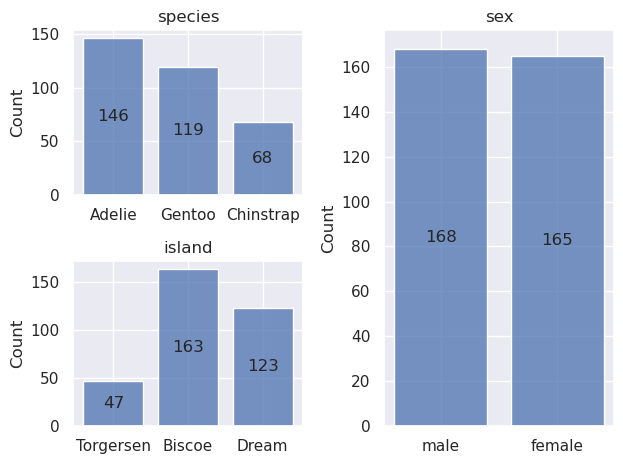

In [7]:
parts = [(2, 2, 1), (2, 2, 3), (1, 2, 2)]
for p, col in zip(parts, categorical):
    ax = plt.subplot(*p)
    sns.histplot(
        data=df,
        x=col,
        ax=ax,
        shrink=0.8,
    )
    for i in ax.containers:
        ax.bar_label(
            container=i,
            label_type="center",
        )
    ax.set_xlabel("")
    ax.set_title(col)
plt.tight_layout()

### 5. Для каждого текстового признака построить мозаику 2D диаграмм рассеяния выбирая в качестве параметров всевозможные пары числовых признаков, аналогично мозаике диаграмм для ирисов.


На основе полученных результатов сделать предварительную оценку качества классификации пингвинов по каждому из трёх текстовых признаков на основе только числовых признаков. 

In [8]:
# for col in categorical:
#     sns.pairplot(df, hue=col, diag_kind="hist")

Признаки линейно неразделимы, за исключением вида Gentoo признака species, который линейно разделим с другими видами.

## Стандартизация

Числовые признаки имеют величины разного масштаба, проведем стандартизацию

In [9]:
numeric = list(df.select_dtypes(exclude=['object']).columns)
args = df[numeric].agg(("mean", "std"))
scaled = df.copy()
scaled[numeric] -= args.loc["mean"]
scaled[numeric] /= args.loc["std"]

# Задание 2. Бинарная классификация персептроном

        Замечание 1: Все классификаторы оформить в виде объектов некоторого написанного вами класса с обязательными конструктором, методами fit() и predict().
        Замечание 2: Для оценку качества работы классификатора использовать метрику качества Accuracy (точность) – доля объектов тестовой выборки, класс которых был распознан правильно.
        Замечание 3: оценку качества работы классификатора выполнять в 2-х вариантах. Сначала используя всю выборку как обучающую и как тестовую (одна оценка accuracy), а потом с разделением исходной выборки на 2 части: 70% - обучающая выборка (по ней будет обучаться классификатор) и 30% - тестовая выборка (объекты этой группы не будут использованы для обучения классификатора). Точность классификации показывать на обеих выборках – обучающей и тестовой. Объяснять различие полученных значений.



### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



In [10]:
train, test = train_test_split(df.index,
                               test_size=0.3,
                               random_state=42)

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
299,1.043619,0.728778,-0.425733,-0.753906,male
210,1.061905,-0.185282,2.071455,1.854090,male
129,-0.528976,0.170185,-0.782474,-0.381335,male
20,-1.589563,0.881121,-0.996518,-0.505525,female
86,-1.827281,-0.032939,-1.139215,-1.002287,female


### Параметры обучения:

,epoch,eta
,20,0.1


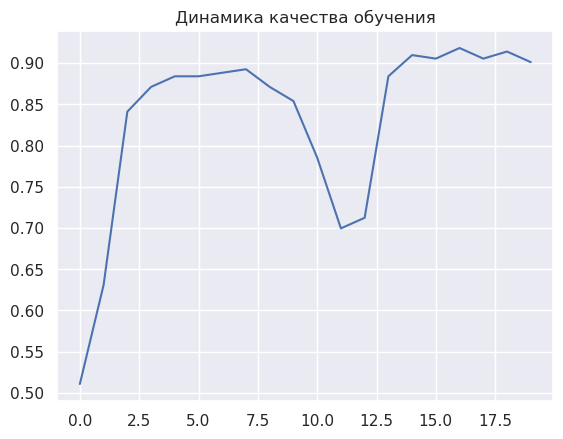

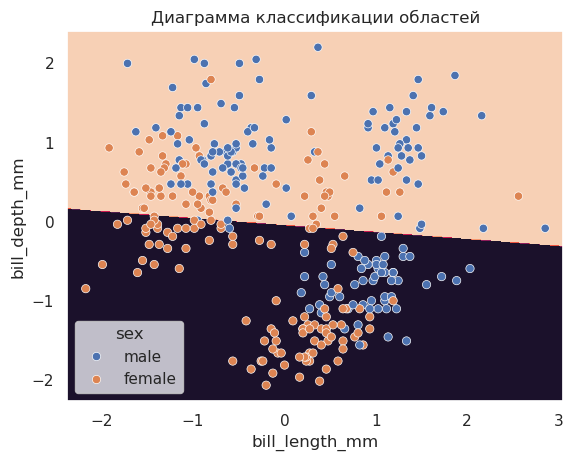

### Оценка качетсва:

Accuracy: 88.00%

In [11]:
model_num = model_report(
    model=Perceptron,
    dataset=scaled,
    X=numeric,
    y="sex",
    train=train,
    train_args=dict(
        epoch=20,
        eta=1e-1
    )
)

### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
131,-0.693550,1.490495,-0.068991,-0.288192,male
92,-1.991855,-0.540750,-1.638652,-1.623238,female
123,0.019604,0.424091,0.644491,-0.257145,male
128,-1.077555,0.220967,-0.996518,-0.971239,female
53,-1.168985,0.982683,-0.497081,-0.567621,male


### Параметры обучения:

,epoch,eta
,20,0.1


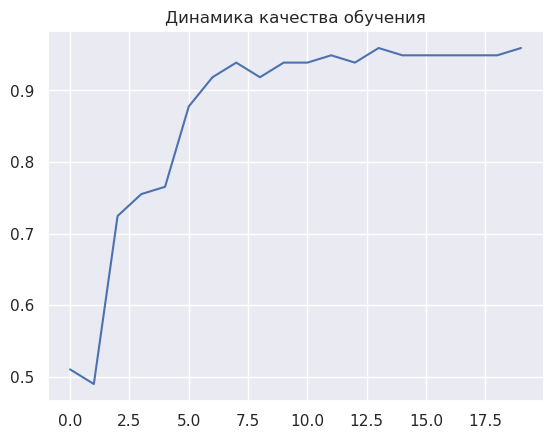

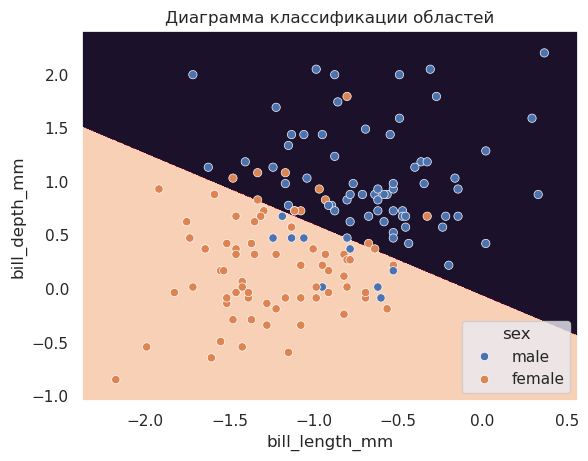

### Оценка качетсва:

Accuracy: 85.42%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
161,0.970475,-0.743875,1.143928,2.040376,male
190,-0.071826,-1.657935,1.143928,0.860568,female
201,-0.035254,-1.657935,0.501794,0.115426,female
227,1.098477,-0.642313,1.643366,1.419424,male
196,0.824187,-1.556373,1.357973,1.357329,male


### Параметры обучения:

,epoch,eta
,20,0.1


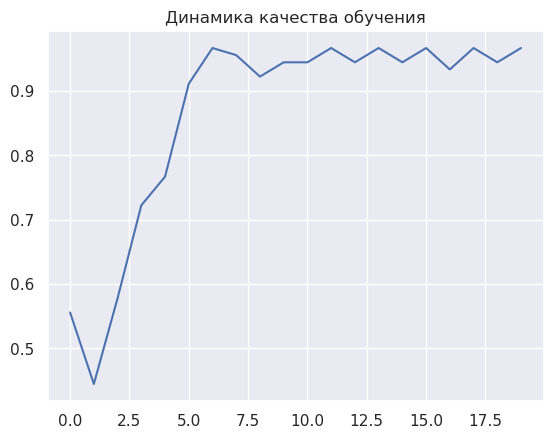

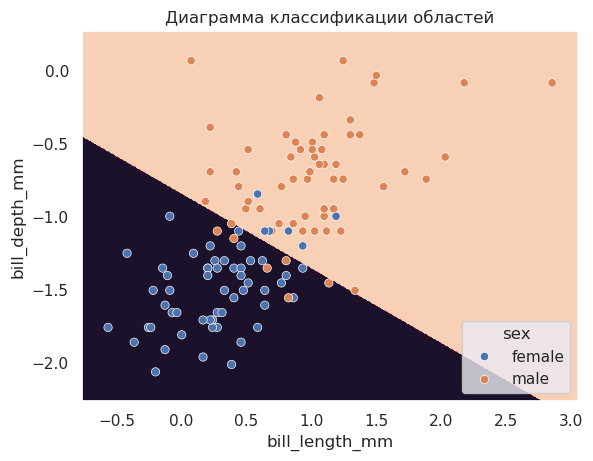

### Оценка качетсва:

Accuracy: 93.10%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
327,0.312180,-0.083720,-0.425733,-0.691811,female
277,0.549898,0.068623,-1.139215,-0.629716,female
271,0.385324,0.525653,-1.638652,-1.188572,female
305,0.915617,1.185808,0.644491,-0.319240,male
331,1.244765,0.931902,0.644491,-0.132954,male


### Параметры обучения:

,epoch,eta
,20,0.1


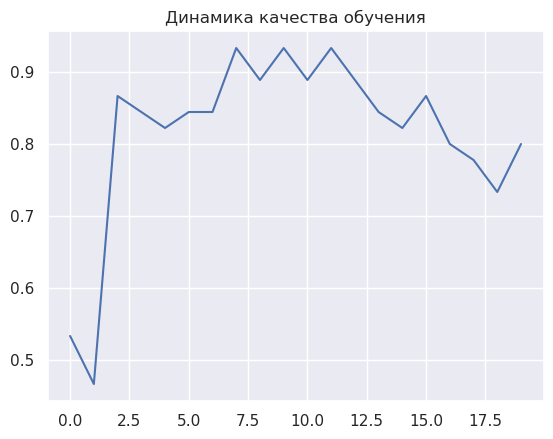

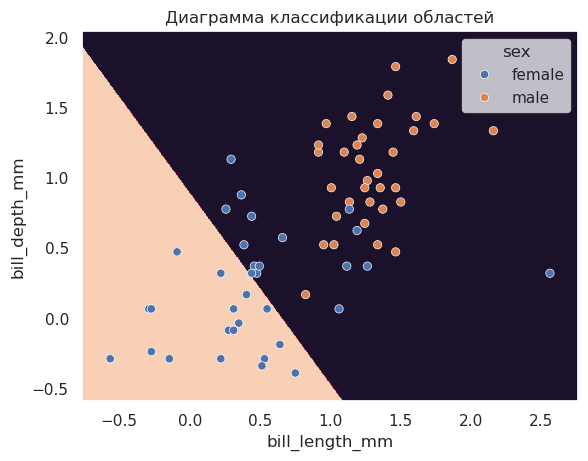

### Оценка качетсва:

Accuracy: 82.61%

In [12]:
models = dict()
for spec in df.species.unique():
    part = scaled[scaled.species==spec]
    part_train = part.index.intersection(train)
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron,
        dataset=part,
        X=numeric,
        y='sex',
        train=part_train,
        train_args=dict(
            epoch=20,
            eta=1e-1
        )
    )

### Сравнение моделей

,Adelie,Gentoo,Chinstrap,All
accuracy,0.854167,0.931034,0.826087,0.88


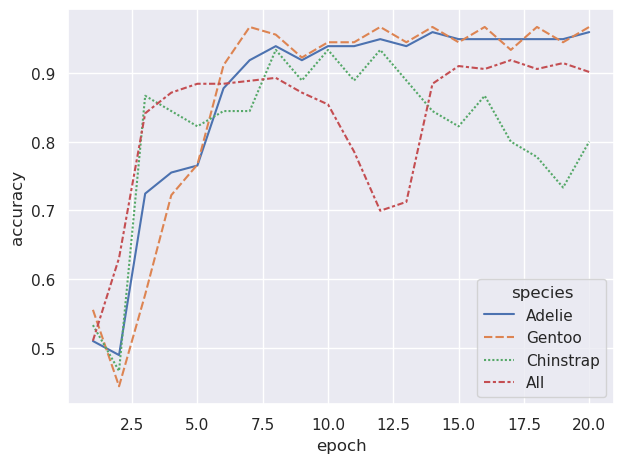

In [13]:
models["All"] = model_num
compare_models(
    models,
    dataset=scaled,
    X=numeric,
    y='sex',
    test=test,
)

На некоторых(Adelie) видах лучше получается разделять (лучше accuracy), т.к. признак 'sex' более линейно разделим.  

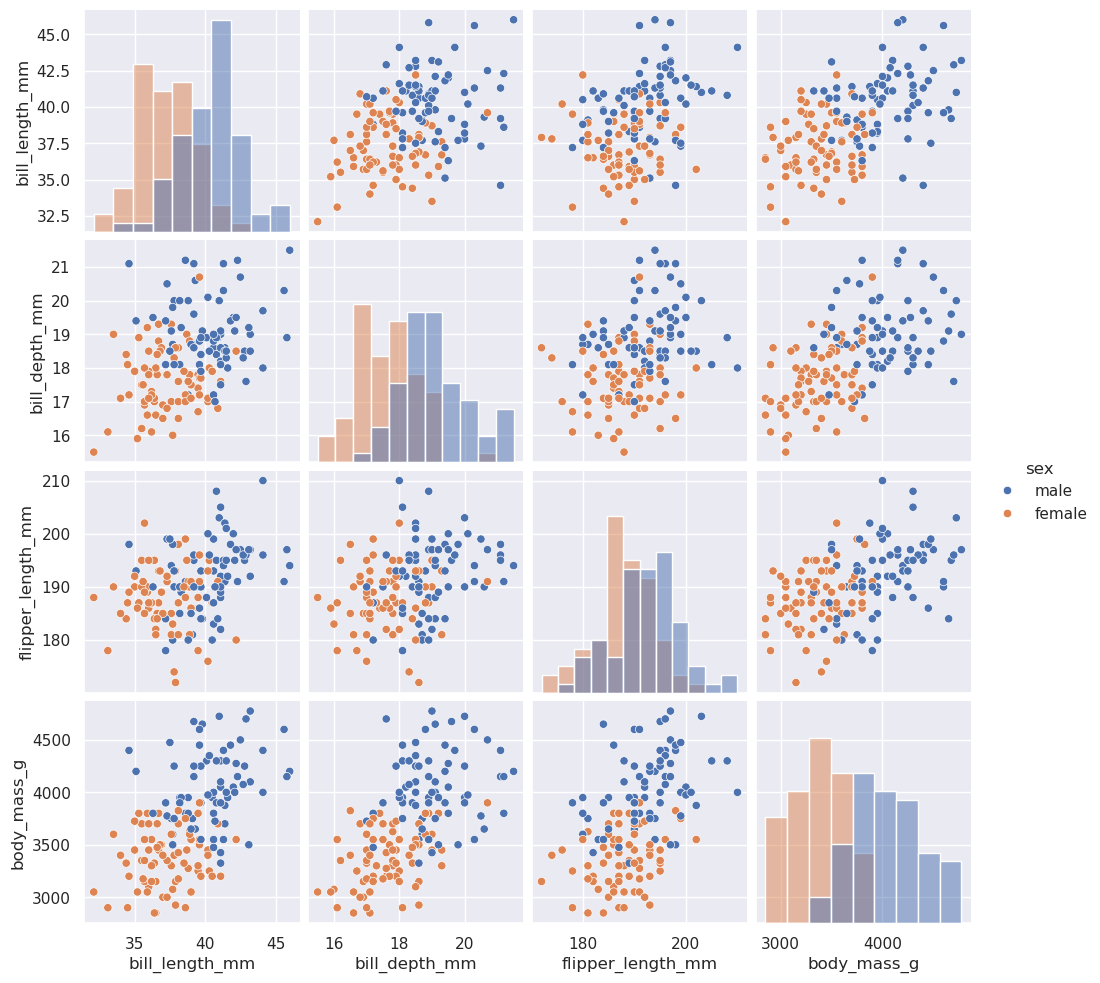

In [14]:
sns.pairplot(df[df['species'] == 'Adelie'], hue="sex", diag_kind="hist")
plt.show()

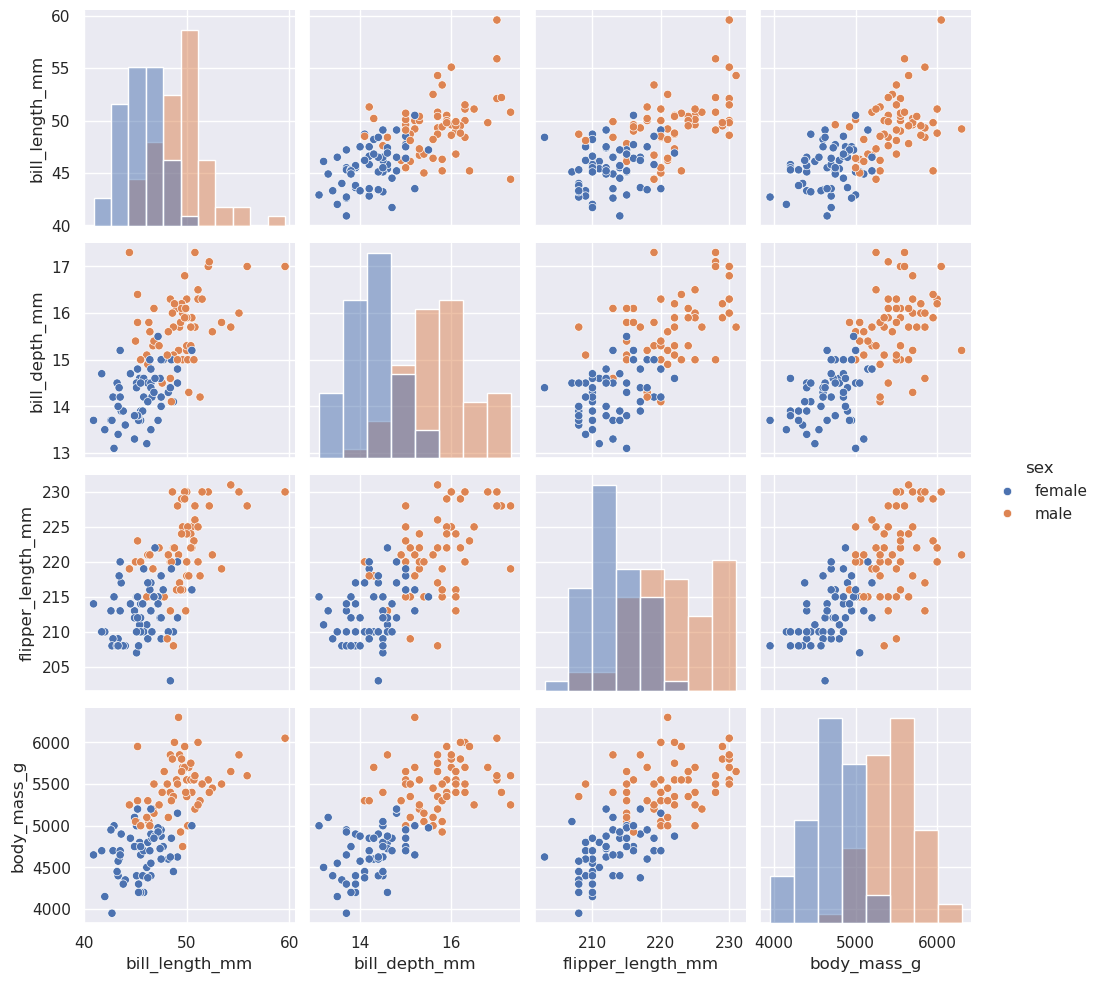

In [15]:
sns.pairplot(df[df['species'] == 'Gentoo'], hue="sex", diag_kind="hist")
plt.show()

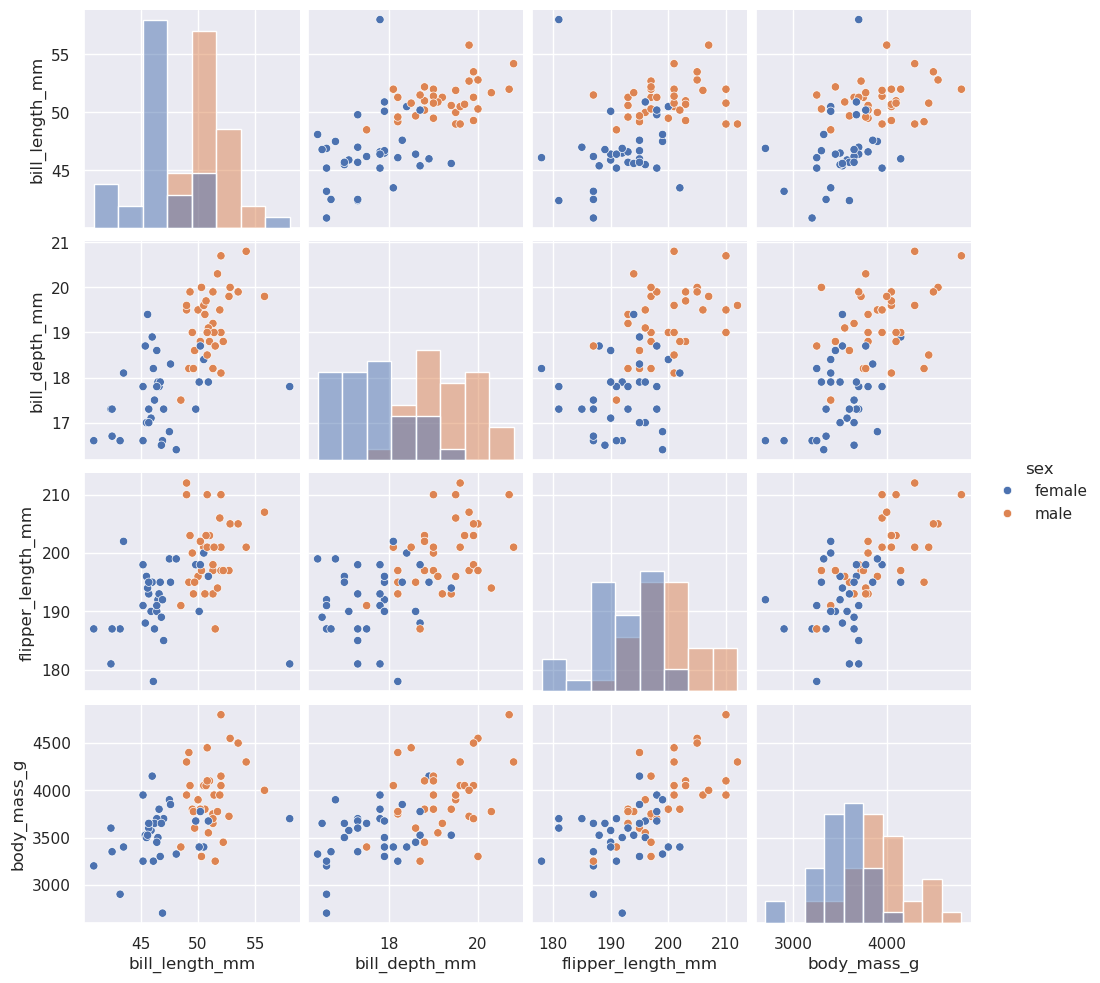

In [16]:
sns.pairplot(df[df['species'] == 'Chinstrap'], hue="sex", diag_kind="hist")
plt.show()

### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).



In [17]:
for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numeric],
        scaled.loc[test, 'sex'],
        text=f'{spec} Accuracy'
    )

Adelie Accuracy: 76.00%
Gentoo Accuracy: 81.00%
Chinstrap Accuracy: 68.00%
All Accuracy: 88.00%


Получился результат на новых данных хуже,


# Задание 3. Бинарная классификация с использованием ADALINE.



Повторите пп.1-3 предыдущего задания, построив классификатор на основе адаптивного нейрона.


### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
89,-0.583834,0.881121,0.501794,0.115426,male
136,-2.174715,-0.845437,-0.925170,-1.436953,female
270,0.220750,0.322529,-0.211688,-0.319240,female
41,-0.528976,0.931902,-1.353259,-0.971239,male
225,1.555627,-0.794656,1.429321,1.543615,male


### Параметры обучения:

,eta,epoch
,0.001,40


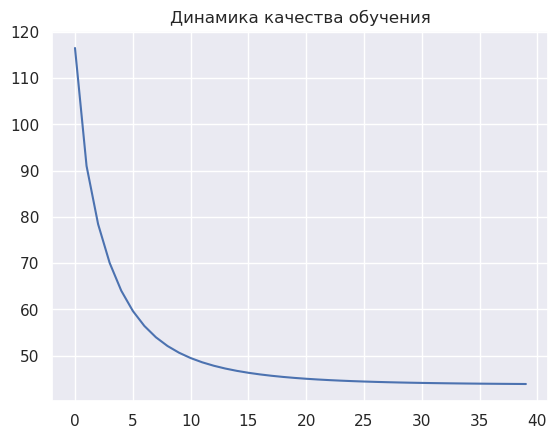

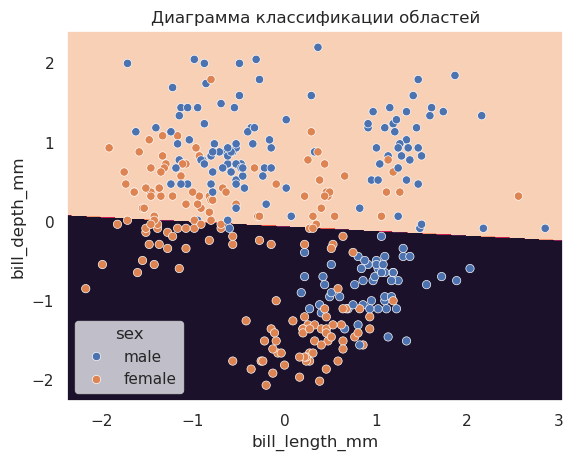

### Оценка качетсва:

Accuracy: 87.00%

In [18]:
model_num_ada = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numeric,
    y="sex",
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40
    )
)

### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
56,-1.168985,-0.083720,-1.139215,-0.753906,female
18,-1.059269,0.474872,-1.139215,-0.319240,male
53,-1.168985,0.982683,-0.497081,-0.567621,male
105,0.293894,1.592057,-0.711125,0.487997,male
125,-0.163256,1.033465,-0.283036,-0.878096,male


### Параметры обучения:

,epoch,eta
,40,0.001


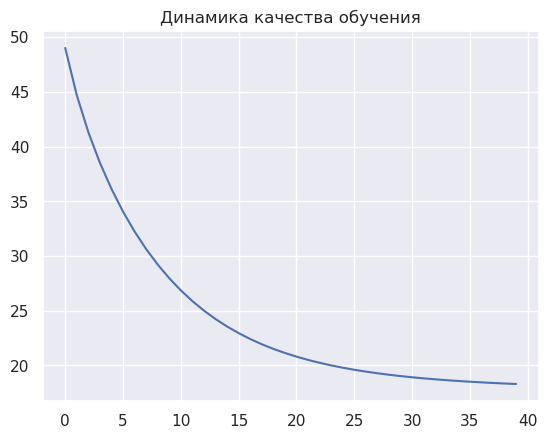

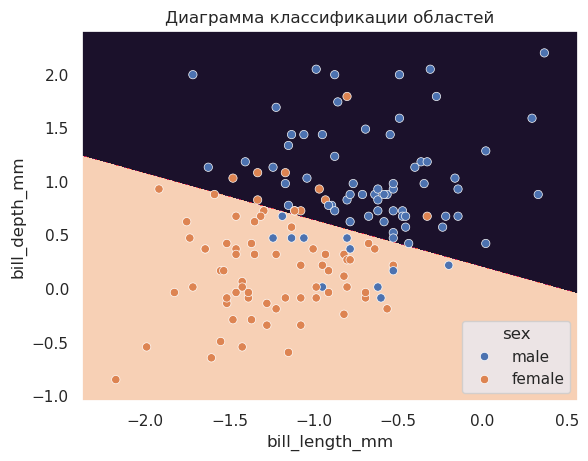

### Оценка качетсва:

Accuracy: 81.25%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
190,-0.071826,-1.657935,1.143928,0.860568,female
215,0.440182,-0.794656,1.429321,0.984758,male
196,0.824187,-1.556373,1.357973,1.357329,male
227,1.098477,-0.642313,1.643366,1.419424,male
166,1.135049,-1.454811,1.215277,1.854090,male


### Параметры обучения:

,epoch,eta
,40,0.001


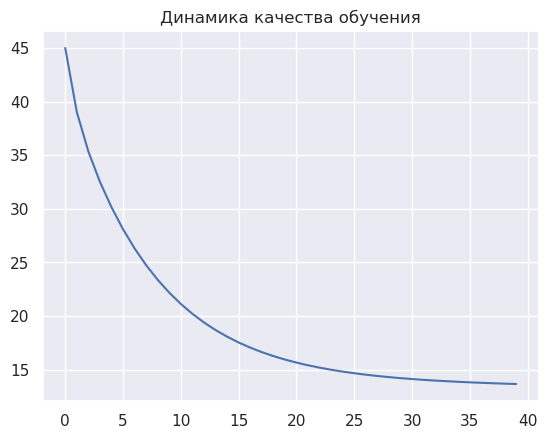

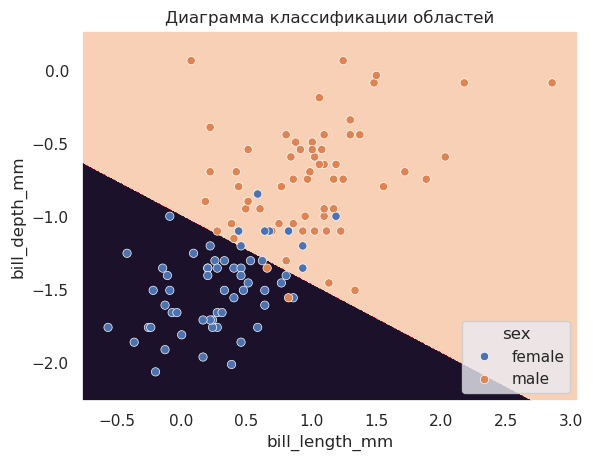

### Оценка качетсва:

Accuracy: 89.66%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
314,1.061905,0.068623,-0.211688,-0.660763,female
304,1.738487,1.388932,0.287750,0.363807,male
285,-0.291258,0.068623,-1.424608,-0.753906,female
326,0.513326,-0.337626,-0.853822,-0.691811,female
306,0.403610,0.170185,-0.996518,-0.691811,female


### Параметры обучения:

,epoch,eta
,40,0.001


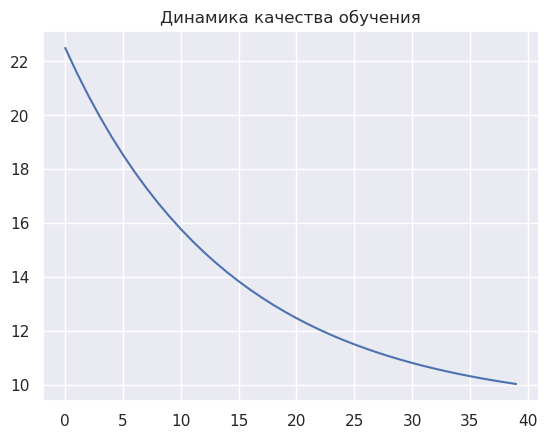

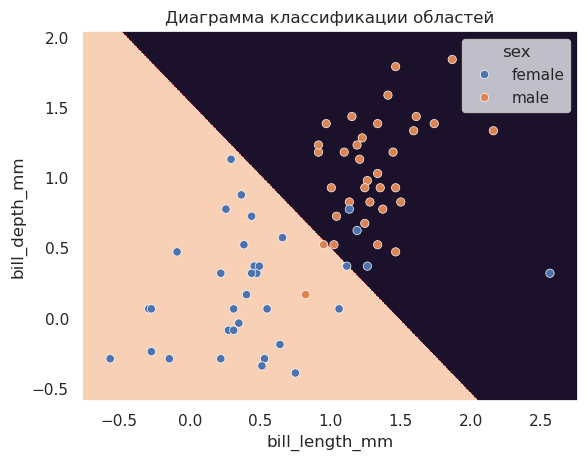

### Оценка качетсва:

Accuracy: 86.96%

In [19]:
models_ada = dict()
for spec in df.species.unique():
    part = scaled[scaled.species == spec]
    part_train = part.index.intersection(train)
    display(Markdown(f"# {spec}"))
    models_ada[spec] = model_report(
        model=Perceptron_ada,
        dataset=part,
        X=numeric,
        y='sex',
        train=part_train,
        train_args=dict(
            epoch=40,
            eta=1e-3
        )
    )

### Сравнение моделей

,Adelie,Gentoo,Chinstrap,All
accuracy,0.8125,0.896552,0.869565,0.87


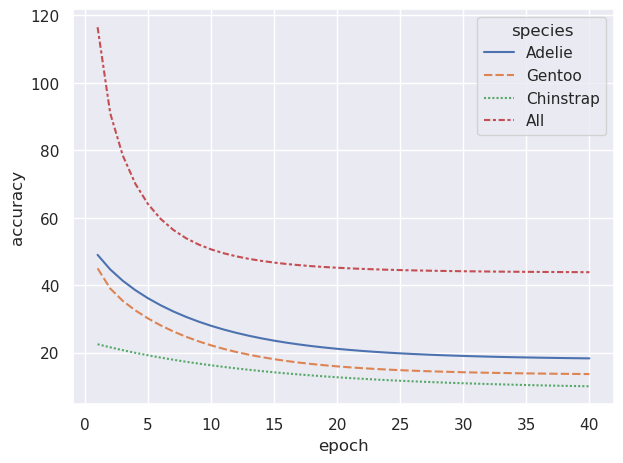

In [20]:
models_ada["All"] = model_num_ada
compare_models(
    models_ada,
    dataset=scaled,
    X=numeric,
    y='sex',
    test=test,
)

### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).


In [21]:
for spec, model in models_ada.items():
    model.print_accuracy(scaled[numeric], df.sex, text=f'{spec} Accuracy')

Adelie Accuracy: 85.89%
Gentoo Accuracy: 84.08%
Chinstrap Accuracy: 72.07%
All Accuracy: 89.79%


### 4. Включите в список признаков вид пингвина, представив его числом (1,2,3) для разных видов. Оцените качество классификации и сравните с результатом пункта 3.1.


In [22]:
scaled['spec_num'] = np.select(
    condlist=[df.species == c
              for c in df.species.unique()],
    choicelist=(1, 2, 3)
)
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num
294,Chinstrap,Dream,1.610485,1.439714,0.287750,0.425902,male,3
280,Chinstrap,Dream,1.189907,1.236589,0.002357,-0.195050,male,3
47,Adelie,Biscoe,-0.364402,1.185808,-0.068991,-0.195050,male,1
322,Chinstrap,Dream,0.970475,1.388932,0.145053,-0.195050,male,3
279,Chinstrap,Dream,0.348752,-0.032939,-0.782474,-0.784954,female,3


### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,spec_num,sex
243,1.299623,-0.337626,1.714714,1.295234,2,male
232,0.641327,-1.607154,0.787187,0.829520,2,female
283,0.440182,0.728778,-0.782474,-0.940192,3,female
304,1.738487,1.388932,0.287750,0.363807,3,male
160,0.330466,-1.302467,0.644491,-0.008764,2,female


### Параметры обучения:

,eta,epoch
,0.001,40


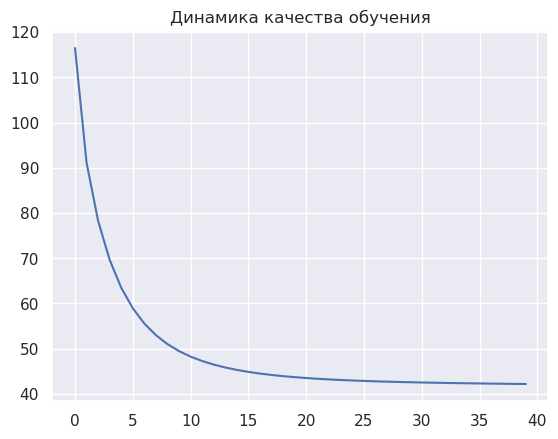

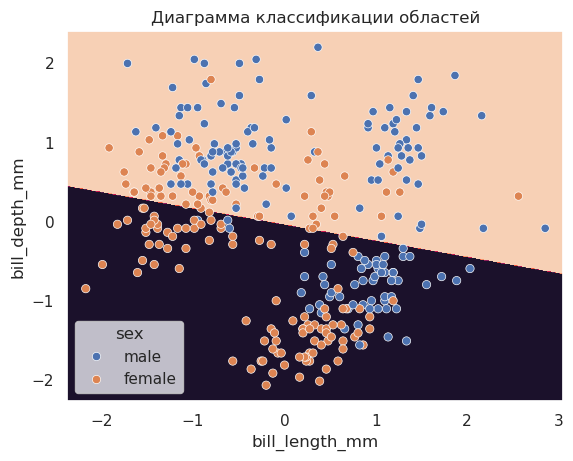

### Оценка качетсва:

Accuracy: 86.00%

In [23]:
_ = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numeric+['spec_num'],
    y='sex',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    )
)

Качество не улучшилось

### 5. Замените признак вид на три бинарных признака Adelie, Chinstrap, Gentoo, в каждом из которых значение 1 соответствует тому, что данный пингвин принадлежит соответствующему виду: 

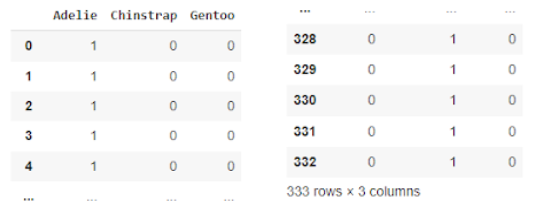

In [24]:
for spec in df.species.unique():
    scaled[spec] = (df.species == spec)*2-1
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num,Adelie,Gentoo,Chinstrap
99,Adelie,Biscoe,-0.784980,0.881121,-1.210563,-0.816001,male,1,1,-1,-1
302,Chinstrap,Dream,1.464197,1.795182,0.644491,0.736378,male,3,-1,-1,1
140,Adelie,Dream,-0.876409,0.728778,-0.782474,0.053331,male,1,1,-1,-1
147,Gentoo,Biscoe,1.098477,-0.439188,2.071455,1.854090,male,2,-1,1,-1
21,Adelie,Biscoe,-0.620406,0.728778,-1.281911,-0.816001,male,1,1,-1,-1


### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Adelie,Gentoo,Chinstrap,sex
54,-1.516419,-0.134501,-1.139215,-1.312762,1,-1,-1,female
277,0.549898,0.068623,-1.139215,-0.629716,-1,-1,1,female
48,-1.735851,0.474872,-0.996518,-1.623238,1,-1,-1,female
210,1.061905,-0.185282,2.071455,1.854090,-1,1,-1,male
142,-1.461561,0.322529,-0.425733,-0.940192,1,-1,-1,female


### Параметры обучения:

,eta,epoch
,0.001,40


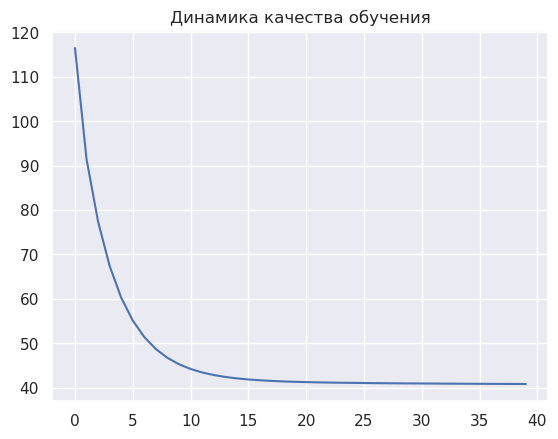

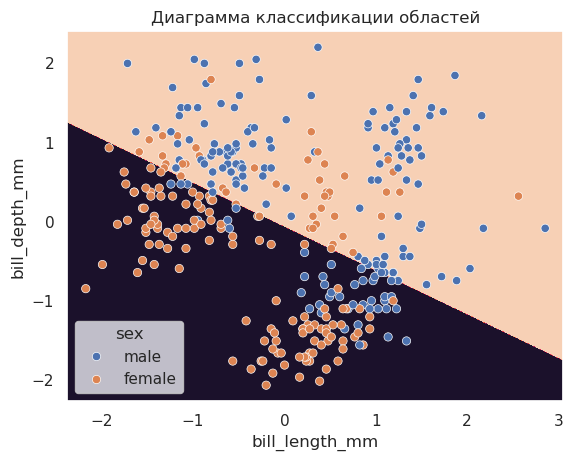

### Оценка качетсва:

Accuracy: 88.00%

In [25]:
numNspec = numeric+list(df.species.unique())
_ = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numNspec,
    y='sex',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    )
)

Выполните классификацию по полу, используя уже 7 числовых признаков. Сравните качество классификации с предыдущими вариантами.


Качество немного улучшилось

### 6. Выполните классификацию по каждому из видов пингвина, используя 5 числовых признаков (4 размера-веса и пол: 1-male, 0-female). Сравните качество классификаторов.

In [26]:
scaled['sex_num'] = (df['sex'] == 'male')*2-1
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num,Adelie,Gentoo,Chinstrap,sex_num
126,Adelie,Dream,-1.315273,0.677997,-0.568429,-0.878096,female,1,1,-1,-1,-1
198,Gentoo,Biscoe,1.116763,-1.099343,1.714714,0.984758,male,2,-1,1,-1,1
256,Gentoo,Biscoe,1.372767,-0.439188,2.071455,1.605710,male,2,-1,1,-1,1
81,Adelie,Dream,-1.296987,0.728778,-0.853822,-0.878096,female,1,1,-1,-1,-1
284,Chinstrap,Dream,0.952189,0.525653,-0.425733,0.239616,male,3,-1,-1,1,1


# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie
133,-0.784980,0.373310,-0.568429,0.053331,1,1
151,0.458468,-1.861060,0.644491,0.425902,-1,-1
65,-0.784980,0.627216,-0.782474,-0.381335,1,1
277,0.549898,0.068623,-1.139215,-0.629716,-1,-1
314,1.061905,0.068623,-0.211688,-0.660763,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


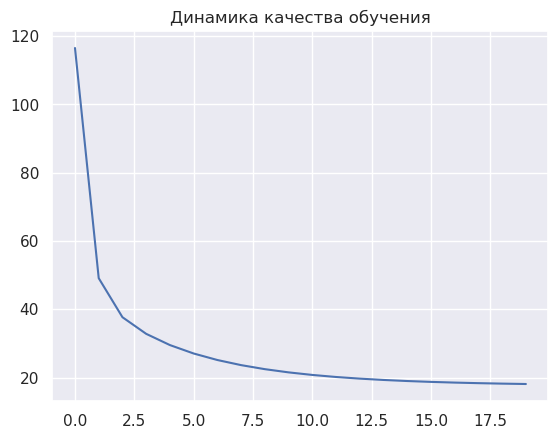

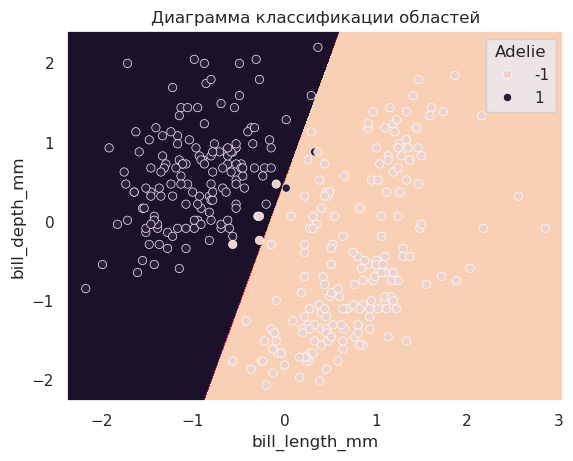

### Оценка качетсва:

Accuracy: 98.00%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Gentoo
252,0.751043,-1.048562,0.573143,1.605710,1,1
279,0.348752,-0.032939,-0.782474,-0.784954,-1,-1
255,-0.090112,-0.997781,0.858536,0.550092,-1,1
287,-0.144970,-0.286845,-0.996518,-1.623238,-1,-1
217,0.458468,-1.200905,1.143928,1.233139,-1,1


### Параметры обучения:

,eta,random_state
,0.001,42


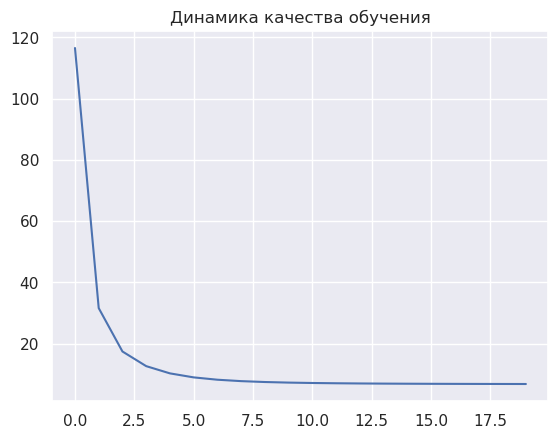

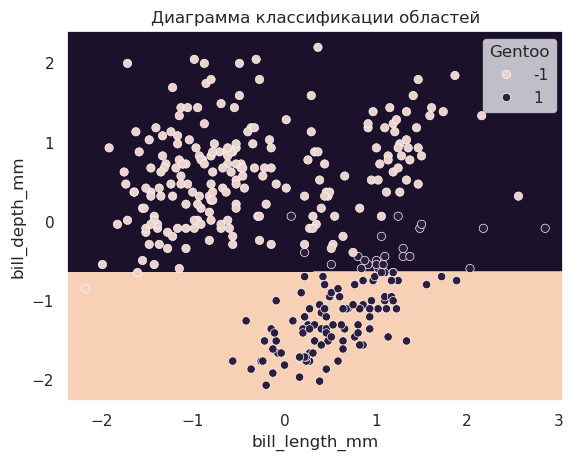

### Оценка качетсва:

Accuracy: 100.00%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Chinstrap
117,-0.474118,0.677997,0.073705,-0.412383,1,-1
87,-0.803266,0.474872,-1.067867,0.301712,1,-1
50,-0.912981,0.170185,-1.067867,-0.816001,-1,-1
165,0.860759,-1.048562,1.500670,1.419424,1,-1
97,-1.132413,1.439714,-0.782474,0.053331,1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


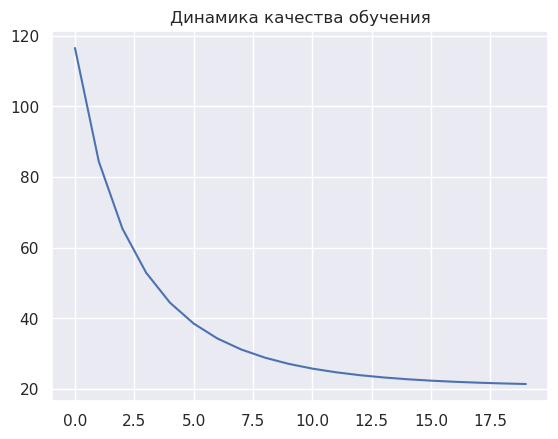

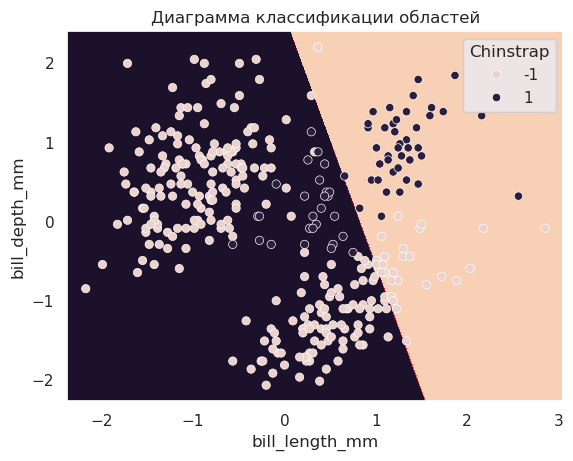

### Оценка качетсва:

Accuracy: 97.00%

Adelie Test Accyracy: 98.00%
Gentoo Test Accyracy: 100.00%
Chinstrap Test Accyracy: 97.00%


In [27]:
numNsex = list(numeric)+["sex_num"]

models = dict()
for spec in df.species.unique():
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron_ada,
        dataset=scaled,
        X=numNsex,
        y=spec,
        train=train,
        train_args=dict(
            eta=1e-3,
            random_state=42,
        )
    )


for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numNsex],
        scaled.loc[test, spec],
        f"{spec} Test Accyracy"
    )

### 7. Повторите предыдущий пункт, добавив к 5 числовым признакам ещё три бинарных, представляющих принадлежность к тому или иному острову.


# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie,Gentoo,Chinstrap,Adelie
289,0.495040,0.373310,-0.425733,-1.126477,-1,-1,-1,1,-1
29,-1.388417,-0.083720,-0.425733,-1.095429,-1,1,-1,-1,1
256,1.372767,-0.439188,2.071455,1.605710,1,-1,1,-1,-1
103,-0.144970,0.931902,-0.283036,0.705330,1,1,-1,-1,1
53,-1.168985,0.982683,-0.497081,-0.567621,1,1,-1,-1,1


### Параметры обучения:

,eta,random_state
,0.001,42


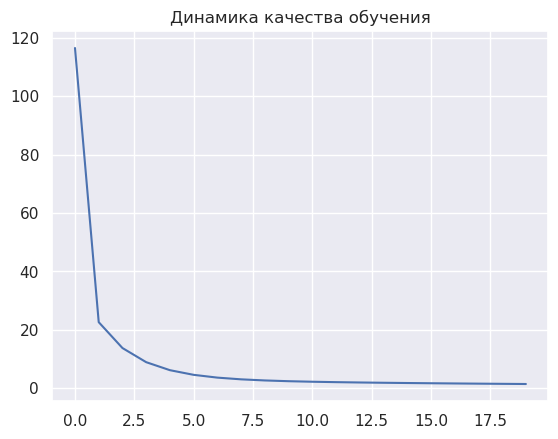

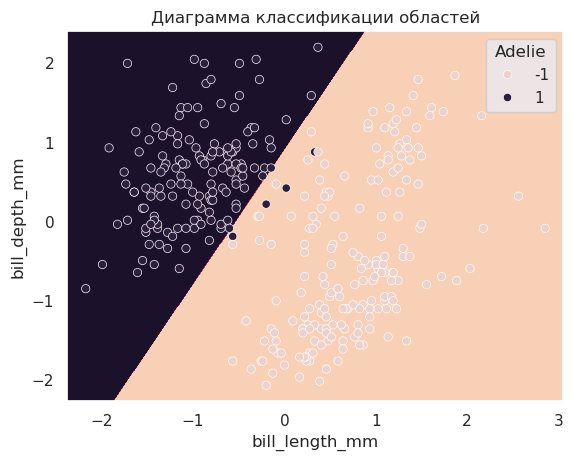

### Оценка качетсва:

Accuracy: 100.00%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie,Gentoo,Chinstrap,Gentoo
210,1.061905,-0.185282,2.071455,1.854090,1,-1,1,-1,1
91,-0.675264,0.677997,-0.354384,0.177521,1,1,-1,-1,-1
131,-0.693550,1.490495,-0.068991,-0.288192,1,1,-1,-1,-1
150,0.659613,-1.353248,1.001232,1.481520,1,-1,1,-1,1
100,-0.986125,0.017842,-0.140340,-0.567621,-1,1,-1,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


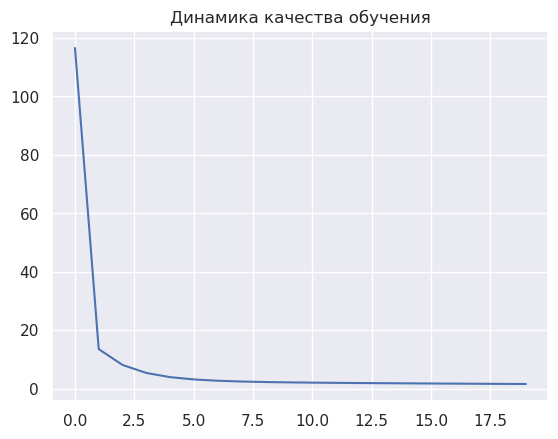

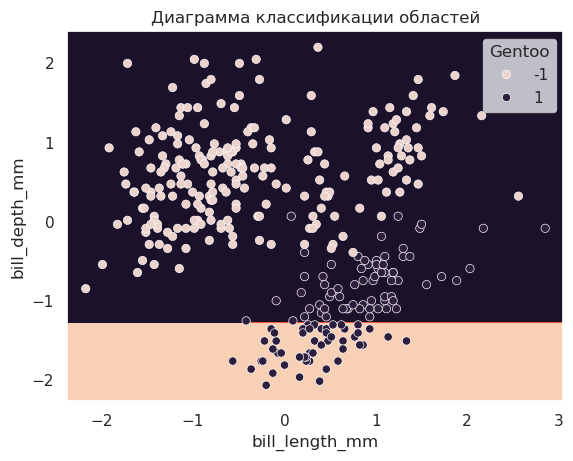

### Оценка качетсва:

Accuracy: 100.00%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie,Gentoo,Chinstrap,Chinstrap
65,-0.784980,0.627216,-0.782474,-0.381335,1,1,-1,-1,-1
29,-1.388417,-0.083720,-0.425733,-1.095429,-1,1,-1,-1,-1
279,0.348752,-0.032939,-0.782474,-0.784954,-1,-1,-1,1,1
286,0.824187,0.170185,-0.711125,-1.002287,1,-1,-1,1,1
2,-0.675264,0.424091,-0.425733,-1.188572,-1,1,-1,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


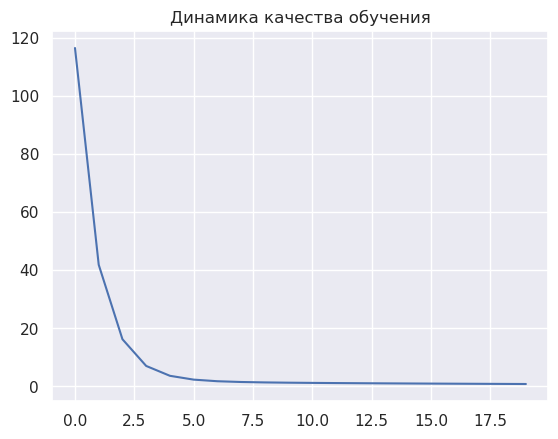

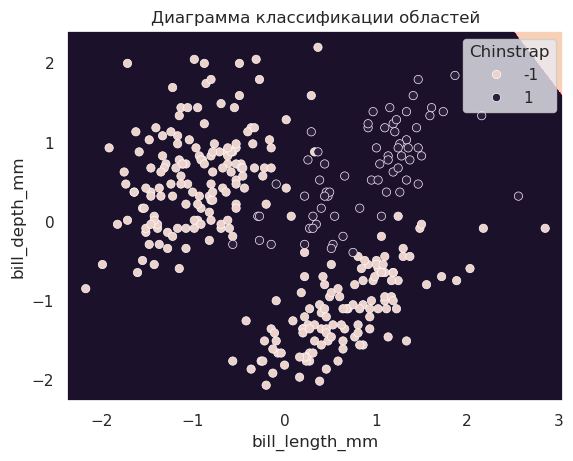

### Оценка качетсва:

Accuracy: 100.00%

Adelie Test Accyracy: 100.00%
Gentoo Test Accyracy: 100.00%
Chinstrap Test Accyracy: 100.00%


In [28]:
numNsexNspec = numNsex + list(df.species.unique())

models = dict()
for spec in df.species.unique():
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron_ada,
        dataset=scaled,
        X=numNsexNspec,
        y=spec,
        train=train,
        train_args=dict(
            eta=1e-3,
            random_state=42,
        )
    )


for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numNsexNspec],
        scaled.loc[test, spec],
        f"{spec} Test Accyracy"
    )

# Задание 4. Множественная классификация с использованием ADALINE.

Постройте сеть из 4 нейронов. На первом слое три из них определяют принадлежность к одному из трёх видов пингвинов. На втором слое на основе оценок 1-го слоя выносится суждение о том, какому из видов принадлежит конкретный объект. Нейрон этого слоя тоже надо обучить.
Провести расчёты в трёх вариантах: используя 4 числовых слоя (только размеры-веса), используя 5 числовых слоёв (+пол), используя 8 числовых слоёв (+остров).
Оценить качество полученных классификаторов. Сделать вывод.



## 1. Используя 4 числовых слоя

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
99,-0.784980,0.881121,-1.210563,-0.816001,Adelie
192,1.189907,-0.642313,1.714714,1.481520,Gentoo
227,1.098477,-0.642313,1.643366,1.419424,Gentoo
244,0.824187,-1.099343,1.286625,0.798473,Gentoo
70,-0.565548,-0.185282,-0.711125,-0.629716,Adelie


### Параметры обучения:

,epoch,eta
,40,0.001


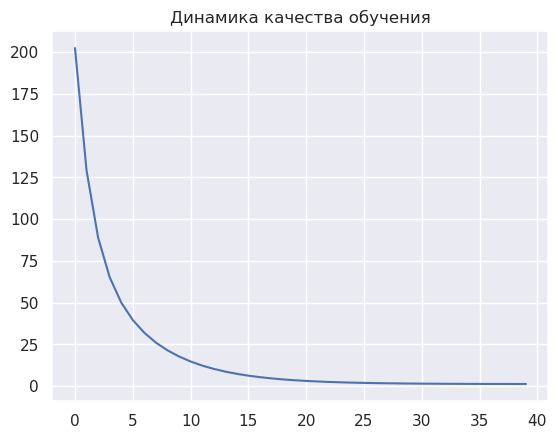

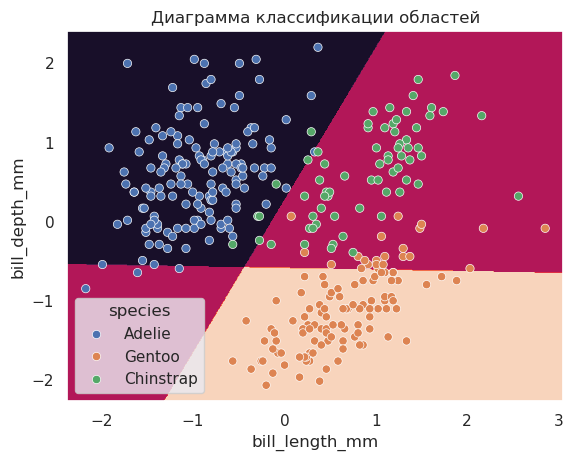

### Оценка качетсва:

Accuracy: 98.00%

In [29]:
_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numeric,
    y="species",
    train=train,
    train_args=dict(
        epoch=40,
        eta=1e-3,
    )
)

Оценка за работу 5 баллов.
Дополнительные 2 балла могут быть выставлены, если обучение каждого классификатора сопровождается выводом графика динамики качества обучения по эпохам и диаграммы классификации областей (оси – два числовых признака размер/вес на выбор студента).


Дополнительный 1 балл за вывод перед каждым обучением информации о характере обучения и первых 5-ти строк обучающей выборки.


## 2. Используя 5 числовых слоёв

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,species
50,-0.912981,0.170185,-1.067867,-0.816001,-1,Adelie
41,-0.528976,0.931902,-1.353259,-0.971239,1,Adelie
254,1.061905,-0.642313,2.000107,2.164566,1,Gentoo
308,0.275608,-0.083720,-0.354384,-0.878096,-1,Chinstrap
331,1.244765,0.931902,0.644491,-0.132954,1,Chinstrap


### Параметры обучения:

,eta,epoch
,0.001,40


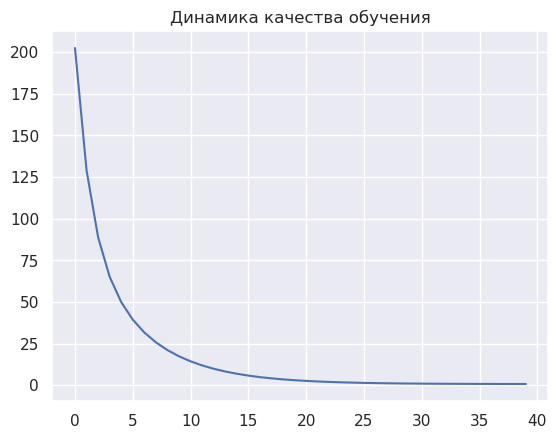

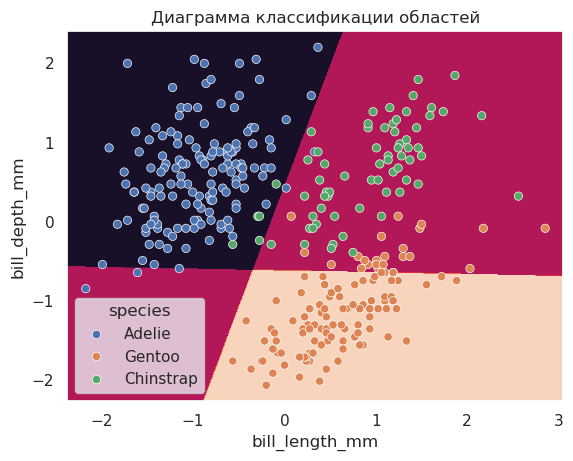

### Оценка качетсва:

Accuracy: 99.00%

In [30]:
_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numNsex,
    y='species',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    ),
)

## 3. Используя 8 числовых слоёв

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie,Gentoo,Chinstrap,species
87,-0.803266,0.474872,-1.067867,0.301712,1,1,-1,-1,Adelie
212,-0.090112,-1.505592,1.357973,0.612187,-1,-1,1,-1,Gentoo
85,-0.528976,0.474872,0.287750,0.115426,1,1,-1,-1,Adelie
58,-1.388417,-0.032939,-1.210563,-1.685333,-1,1,-1,-1,Adelie
21,-0.620406,0.728778,-1.281911,-0.816001,1,1,-1,-1,Adelie


### Параметры обучения:

,eta,epoch
,0.001,40


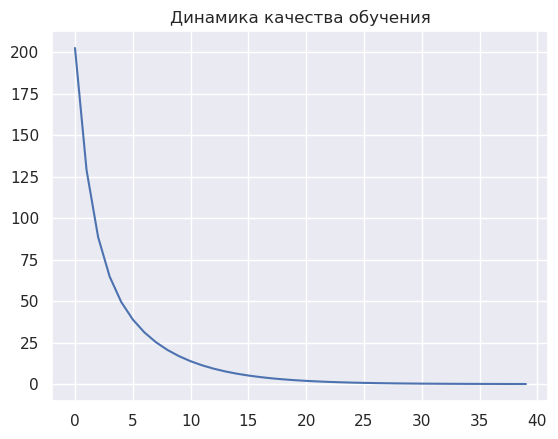

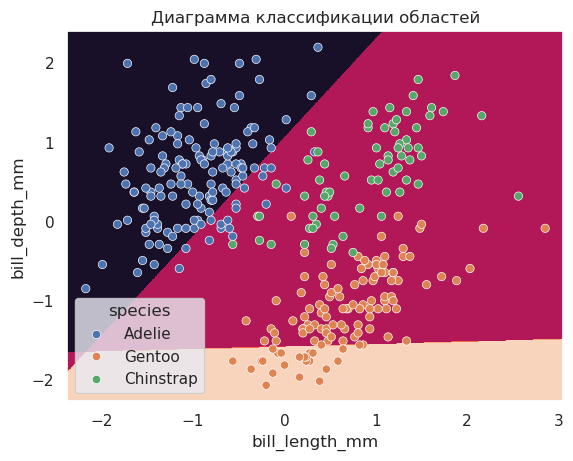

### Оценка качетсва:

Accuracy: 100.00%

In [31]:
numNsexNspec = numNsex + list(df.species.unique())
_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numNsexNspec,
    y='species',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    ),
)

Вывод, чем больше информации, тем лучше